In [1]:
import csv
import chess
import chess.pgn
import io
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    r2_score,
    silhouette_score,
)
from warnings import filterwarnings
from io import StringIO

In [2]:
print(chess.__version__)

1.10.0


In [3]:
pgn_file = "CHUNK/chunk_1.pgn"

In [4]:
def parse_pgn_to_dataframe(pgn_file_path):
    games_data = []
    with open(pgn_file_path, "r", encoding="utf-8") as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            game_data = {
                "Event": game.headers.get("Event", ""),
        "Site": game.headers.get("Site", ""),
        "Date": game.headers.get("Date", ""),
        "Round": game.headers.get("Round", ""),
        "White": game.headers.get("White", ""),
        "Black": game.headers.get("Black", ""),
        "Result": game.headers.get("Result", ""),
        "UTCDate": game.headers.get("UTCDate", ""),
        "UTCTime": game.headers.get("UTCTime", ""),
        "WhiteElo": game.headers.get("WhiteElo", ""),
        "BlackElo": game.headers.get("BlackElo", ""),
        "WhiteRatingDiff": game.headers.get("WhiteRatingDiff", ""),
        "BlackRatingDiff": game.headers.get("BlackRatingDiff", ""),
        "ECO": game.headers.get("ECO", ""),
        "Opening": game.headers.get("Opening", ""),
        "TimeControl": game.headers.get("TimeControl", ""),
        "Termination": game.headers.get("Termination", ""),
        # 將棋步轉換為 UCI 格式
        "Moves": " ".join(move.uci() for move in game.mainline_moves()),
            }
            games_data.append(game_data)
    return pd.DataFrame(games_data)
def convert_pgn_to_parquet(pgn_file_path, parquet_file_path):
    df = parse_pgn_to_dataframe(pgn_file_path)
    df.to_parquet(parquet_file_path, engine="pyarrow")
    print(f"成功將 {pgn_file_path} 轉為 {parquet_file_path}")

In [5]:
parquet_file = "PARQUET/test.parquet"
convert_pgn_to_parquet(pgn_file, parquet_file)

成功將 CHUNK/chunk_1.pgn 轉為 PARQUET/test.parquet


In [10]:
DATA_PATH = "PARQUET/"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Blitz and Rated Rapid games from 2024/8.\n")

Loaded 10751 Rated Blitz and Rated Rapid games from 2024/8.



In [11]:
print(f"Number of Games: {len(df)}")
print(
    "Number of Unique Players: "
    f"{dd.concat([df['White'], df['Black']]).nunique().compute()}"
)
display(df.head())

Number of Games: 10751
Number of Unique Players: 14883


,Event,Site,Date,Round,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,Moves
0,Rated Bullet game,https://lichess.org/nQ1xYNSF,2024.08.01,-,kingskreamer,mysteryvabs,1-0,2024.08.01,00:00:09,2148,2155,+6,-6,B10,Caro-Kann Defense: Accelerated Panov Attack,60+0,Time forfeit,e2e4 c7c6 c2c4 d7d5 c4d5 c6d5 e4d5 d8d5 b1c3 d...
1,Rated Bullet game,https://lichess.org/OHjUyPjz,2024.08.01,-,Paparino,Jorge0912,1-0,2024.08.01,00:00:09,1103,1106,+5,-6,B32,Sicilian Defense: Franco-Sicilian Variation,60+0,Time forfeit,e2e4 c7c5 g1f3 b8c6 d2d4 e7e6 d4c5 f8c5 f1b5 d...
2,Rated Bullet game,https://lichess.org/JHXDBvOM,2024.08.01,-,Ahmed7adel77,jcsobarzok,0-1,2024.08.01,00:00:09,674,629,-7,+7,C50,Italian Game: Paris Defense,60+0,Time forfeit,e2e4 e7e5 g1f3 d7d6 f1c4 b8c6 d2d3 f8e7 e1g1 g...
3,Rated Bullet game,https://lichess.org/4v0QnPHM,2024.08.01,-,KBG1,Kaara_619,0-1,2024.08.01,00:00:09,2459,2556,-4,+5,B40,"Sicilian Defense: Delayed Alapin Variation, wi...",60+0,Normal,e2e4 c7c5 g1f3 e7e6 c2c3 d7d5 d2d4 d5e4 f3e5 c...
4,Rated Bullet game,https://lichess.org/G1Zz3T70,2024.08.01,-,Realsam48,segama,0-1,2024.08.01,00:00:09,1527,1500,-6,+6,B10,Caro-Kann Defense: Breyer Variation,60+0,Time forfeit,e2e4 c7c6 d2d3 d7d5 g2g3 g8f6 e4d5 c6d5 f1g2 c...


In [8]:
# Merge the counts into one, as the player's side isn't important.
white_rating_count = df["WhiteElo"].value_counts().compute()
black_rating_count = df["BlackElo"].value_counts().compute()
rating_counts = (
    pd.concat([white_rating_count, black_rating_count], axis=1).fillna(0).astype(int)
)
rating_counts = rating_counts.sum(axis=1)
rating_counts.index = rating_counts.index.astype(int)
# Find the minimum and maximum player rating.
max_rating = rating_counts.index.max()
min_rating = rating_counts.index.min()
print(f"Maximum Player Rating: {max_rating}")
print(f"Minimum Player Rating: {min_rating}")

# Define the bin edges for player ratings from 600 (minimum in Lichess) to
# 3600 in intervals of 200.

rating_bins = np.arange(600, 3601, 200)
rating_counts.index = pd.cut(rating_counts.index, bins=rating_bins)
merged_rating_counts = rating_counts.groupby(level=0).sum()
display(merged_rating_counts)

Maximum Player Rating: 3156
Minimum Player Rating: 400


(600, 800]       225
(800, 1000]      841
(1000, 1200]    1798
(1200, 1400]    2751
(1400, 1600]    3565
(1600, 1800]    4143
(1800, 2000]    3990
(2000, 2200]    2445
(2200, 2400]    1153
(2400, 2600]     410
(2600, 2800]     120
(2800, 3000]      11
(3000, 3200]      19
(3200, 3400]       0
(3400, 3600]       0
dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_11120\3439380959.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(indexes, rotation=60)


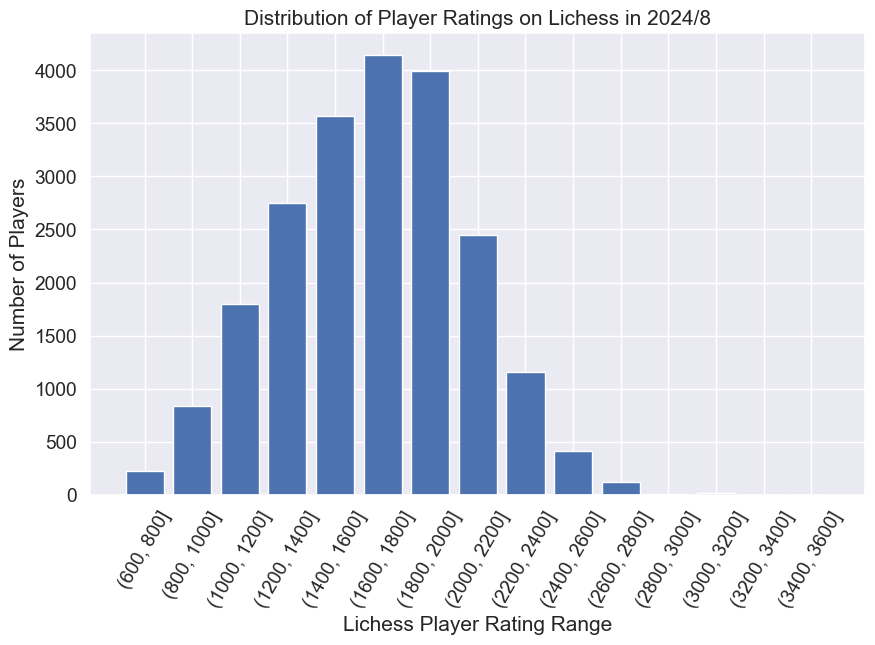

In [13]:
# Plot a graph to show the distribution of player ratings.
sns.set_theme(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_rating_counts.index.astype(str)
values = merged_rating_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Player Ratings on Lichess in 2024/8")
ax.set_xlabel("Lichess Player Rating Range")
ax.set_ylabel("Number of Players")
ax.set_xticklabels(indexes, rotation=60)
plt.show()

In [14]:
# Find the most common ECO categories.
eco_categories = df["ECO"].str[0].value_counts().compute()
print("All Players:")
display(eco_categories)

All Players:


ECO
?      26
A    2911
B    3169
C    3097
D    1390
E     158
Name: count, dtype: int64[pyarrow]

C:\Users\user\AppData\Local\Temp\ipykernel_11120\2397242932.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


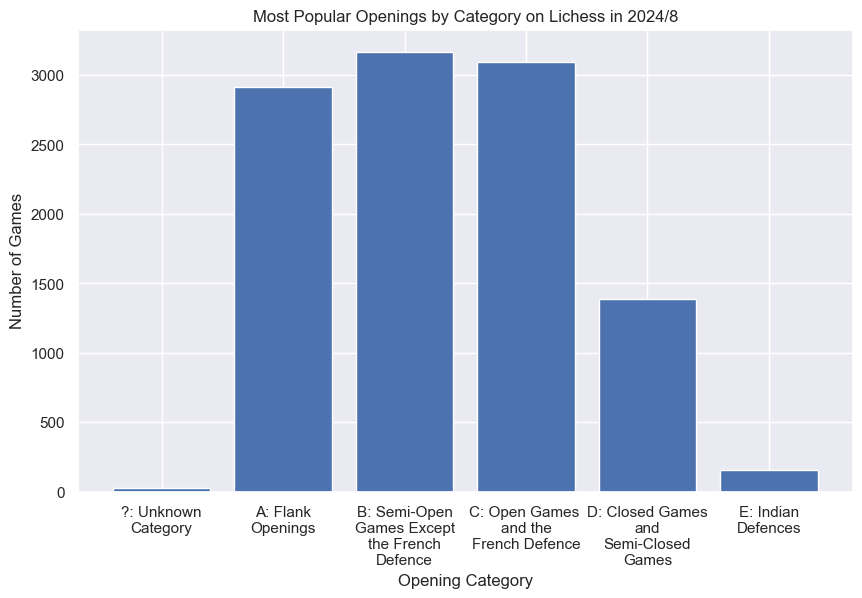

In [16]:
# Map each opening category to its type.
opening_category_map = {
    "A": "Flank\nOpenings",
    "B": "Semi-Open\nGames Except\nthe French\nDefence",
    "C": "Open Games \nand the\nFrench Defence",
    "D": "Closed Games\nand\nSemi-Closed\nGames",
    "E": "Indian\nDefences",
    "?": "Unknown\nCategory",
}

# Plot the number of games in each opening category.
sns.set_theme(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = eco_categories.index
values = eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2024/8")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()

In [48]:
def analyze_game(game):
    """分析棋局以提取棋手風格特徵"""
    board = game.board()
    #print(board)
    moves = list(game.mainline_moves())
    features = {
        "early_center_control": 0,  # 開局中心控制
        "piece_sacrifices": 0,      # 犧牲
        "king_activity": 0,         # 王的活躍性
        "passed_pawns": 0,          # 通路兵
        "tactical_moves": 0         # 戰術進攻
    }
    
    for move_index, move in enumerate(moves):
        board.push(move)
        #print(board)
        #move_san = board.san(move)

        # 開局中心控制 (e4, d4, c4 等)
        if move_index < 10 and move.uci()[:2] in {"e2", "d2", "c2", "e7", "d7", "c7"}:
            features["early_center_control"] += 1

        # 戰術犧牲檢測 (是否存在犧牲)
        if board.is_capture(move) and board.is_attacked_by(not board.turn, move.to_square):
            features["piece_sacrifices"] += 1

        # 殘局王的活躍性 (王進入敵方半區)
        if board.fullmove_number > 40:
            king_square = board.king(board.turn)
            if board.turn == chess.WHITE and chess.square_rank(king_square) > 4:
                features["king_activity"] += 1
            elif board.turn == chess.BLACK and chess.square_rank(king_square) < 3:
                features["king_activity"] += 1

        # 推進通路兵
        piece = board.piece_at(move.to_square)
        if piece and piece.piece_type == chess.PAWN and not board.is_attacked_by(not board.turn, move.to_square):
            features["passed_pawns"] += 1

        # 簡單戰術判斷（如將軍與連續攻擊）
        if board.is_check():
            features["tactical_moves"] += 1

    # 統計結果
    return features

def determine_style(features):
    """根據特徵數據判斷棋手風格"""
    if features["piece_sacrifices"] > 2 or features["tactical_moves"] > 5:
        return "進攻型棋手"
    elif features["early_center_control"] > 5:
        return "控制型棋手"
    elif features["passed_pawns"] > 3 or features["king_activity"] > 2:
        return "殘局型棋手"
    else:
        return "均衡型棋手"

with open(pgn_file, "r", encoding="utf-8") as pgn:
    game = chess.pgn.read_game(pgn)
    features = analyze_game(game)
    style = determine_style(features)

print("特徵數據：", features)
print("棋手風格：", style)

特徵數據： {'early_center_control': 4, 'piece_sacrifices': 63, 'king_activity': 6, 'passed_pawns': 11, 'tactical_moves': 8}
棋手風格： 進攻型棋手


In [43]:
# 定义输入和输出文件路径
input_file = "CHUNK/chunk_1.pgn"  # 上传的文件路径
output_file = "chess_games.csv"  # 输出的CSV文件路径
output_file_test = "chess_games_test.csv"  # 输出的CSV文件路径
number = 0
# 统计棋局总数
total_games = 0
with open(input_file, "r", encoding="utf-8") as pgn:
    while chess.pgn.read_game(pgn) is not None:
        total_games += 1
# 设置只读取总数减 1 的棋局
max_games = total_games - 1
games_processed = 0
fieldnames = []  # 保持原顺序
games = []  # 用于存储每盘棋局数据
with open(input_file, "r", encoding="utf-8") as pgn:
    while games_processed < max_games:
        game = chess.pgn.read_game(pgn)
        if game is None:  # 如果没有更多棋局
            break

        # 收集字段名
        headers = game.headers
        for key in headers.keys():
            if key not in fieldnames:  # 按照出现顺序添加字段名
                fieldnames.append(key)

        # 添加棋局数据
        game_data = headers.copy()
        game_data["Moves"] = game.mainline_moves()  # 移动序列
        games.append(game_data)
        games_processed += 1

# 最后添加 "Moves" 列
if "Moves" not in fieldnames:
    fieldnames.append("Moves")

# 写入 CSV 文件
with open(output_file_test, "w", newline="", encoding="utf-8") as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    csv_writer.writeheader()  # 写入表头
    for game_data in games:
        csv_writer.writerow(game_data)

print(f"全部棋局（不含最后一局）已保存到 CSV 文件：{output_file}")

全部棋局（不含最后一局）已保存到 CSV 文件：chess_games.csv


In [10]:
games_processed = 0
with open(input_file, "r", encoding="utf-8") as pgn:
    while games_processed < 1:
        game = chess.pgn.read_game(pgn)
        if game is None:  # 如果没有更多棋局
            break

        # 收集字段名
        headers = game.headers
        for key in headers.keys():
            if key not in fieldnames:  # 按照出现顺序添加字段名
                fieldnames.append(key)

        # 添加棋局数据
        game_data = headers.copy()
        game_data["Moves"] = game.mainline_moves()  # 移动序列
        games.append(game_data)
        games_processed += 1
        print(game_data["Moves"])

1. d4 g6 2. c4 Bg7 3. Nc3 b6 4. e4 Bb7 5. f3 c6 6. Be3 a5 7. Qd2 f6 8. Nge2 g5 9. Ng3 e6 10. Nh5 Bh6 11. h4 gxh4 12. Bxh6 Nxh6 13. Qxh6 d6 14. Nxf6+ Ke7 15. Rxh4 e5 16. Qg7+ Ke6 17. d5+ cxd5 18. cxd5+ Bxd5 19. exd5+ Kf5 20. Bd3+ e4 21. Bxe4+ Ke5 22. Nh5+ Qf6 23. Qxf6#
